In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
box = np.fromfile('boxes.gz/boxes/deltaTb_z6.000_fesc_0.89_A_3.83e-01_C_0.45_m_0.230_h_0.687_s_0.848.dat', dtype=np.float32).reshape(200,200,200)*1e3

rms slice 8.970317


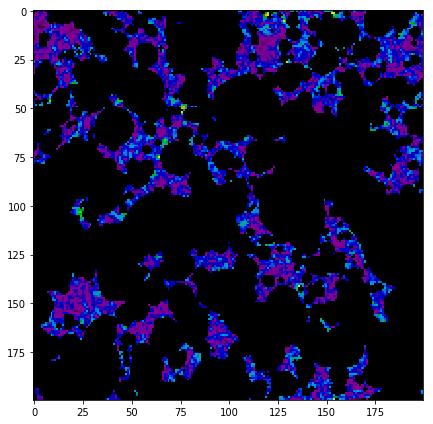

In [32]:
image = box[:,:,160]

print ('rms slice', np.std(image))

fig,ax = plt.subplots(1, figsize=(8,6))
ax.imshow(image, cmap='nipy_spectral')
fig.tight_layout()
plt.show()

In [33]:
FFT = np.fft.fftn(box,norm="ortho")

In [34]:
#Calculate frequency resolution
#dnu=  nu0 Hz *  dx  / c *(1+z)**2,
nu0 = 1420.40575177 #MHz
#Hz  = H0 * sqt(omega_m * (1+z)^3  + omega_l)
Hz  = 70*np.sqrt(0.3*(1+8.)**3. + (1. - 0.7 )) 
dx  = 500./200. 
c   = 299792.458 # km/s 

dnu = nu0*Hz * dx / (  c* (1+8.)**2.  ) 

dnu, "MHz"


(0.15148401472872605, 'MHz')

In [35]:
fftfreq = 2*np.pi*np.fft.fftfreq(200,dnu)

##The loop to account for Foreground cleaning.
ndim = 200
m = 1.0
for i in range(ndim):
    for j in range(ndim):
        for l in range(ndim):
            k_perp = np.sqrt(fftfreq[i]**2.0 + fftfreq[j]**2.0)
            k_parallel = fftfreq[l]
            if k_perp*m > k_parallel:
                FFT[i,j,l] = 0

#Inverse Fourier of the box
IFFT2 = np.fft.ifftn(FFT,norm="ortho")

#Taking the real part of the box
rFFT = np.real(IFFT2)

In [36]:
# requires how many slices to get to 1 MHz

int(1.0 / dnu), 'slices'

(6, 'slices')

rms slice 8.970317 6.8334355


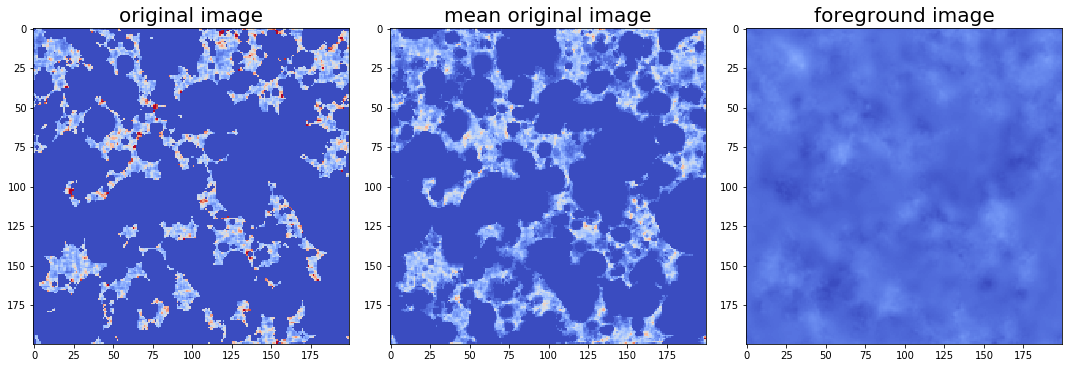

In [54]:
#check the average over 6 slices!

image   = box[:,:,160]
image_z = np.mean(box[:,:,160:166], axis=2)
image_foreg = np.mean(rFFT[:,:,160:166], axis=2)


print ('rms slice', np.std(image), np.std(image_z) )

vmin, vmax = min( [min(image.flatten()), min(image.flatten())] ), max( [ max(image_z.flatten()), max(image_z.flatten())])

clr = 'coolwarm'

fig,ax = plt.subplots(1,3,  figsize=(15,10))
ax[0].imshow(image, vmin=vmin, vmax=vmax, cmap=clr)
ax[0].set_title('original image', fontsize=20)
ax[1].imshow(image_z, vmin=vmin, vmax=vmax, cmap=clr)
ax[1].set_title('mean original image', fontsize=20)
ax[2].imshow(image_foreg, vmin=vmin, vmax=vmax, cmap=clr)
ax[2].set_title('foreground image', fontsize=20)
fig.tight_layout()
plt.show()

In [55]:
# now lets chack the noise:
sigma_mk = 973*1.0e-6*1.0e-26/( 5. /60*np.pi/180)**2*(0.21*1420/190)**2/2/1.38064852e-23*np.sqrt(1.0e-4*190/1000)*1000
sigma_mk

1.788514010688016

In [56]:

theta = dx / 8943.15472063  * (3437.75)
round(theta), 'arcmin'

(1, 'arcmin')

In [57]:
from skimage.transform import resize


resize_image       =  resize(image_z, (40, 40), mode='wrap', anti_aliasing=True)
resize_f_image       =  resize(image_foreg, (40, 40), mode='wrap', anti_aliasing=True)

noise              =  np.random.normal(loc=0.0, scale=sigma_mk, size=(40,40))

print ( "rms resize", np.std(resize_image))

rms resize 4.985530169807684


rms original resize =  5.316071512338062 , rms original =  6.8334355
rms noise + foreground resize =  2.18597156688416 , rms foreground =  1.3582555


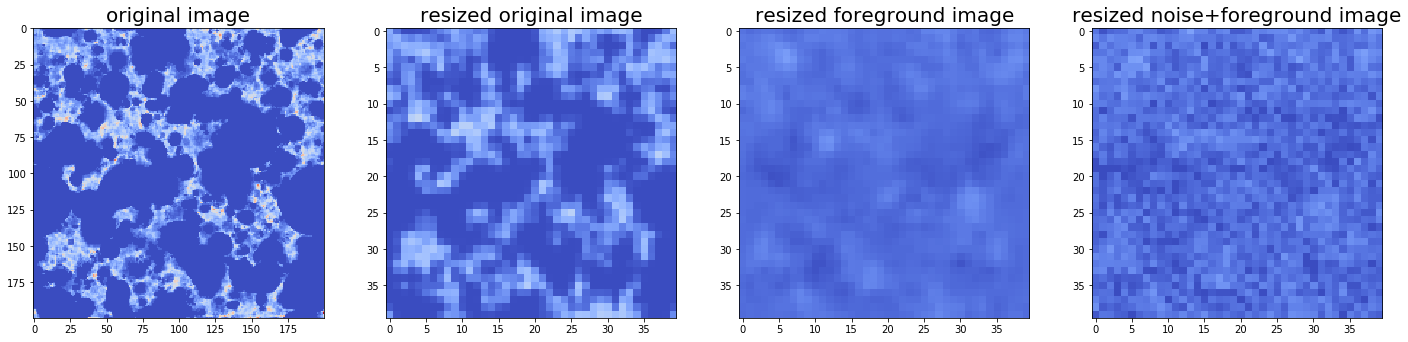

In [58]:
print ( "rms original resize = ", np.std(resize_image + noise), ", rms original = ", np.std(image_z))
print ( "rms noise + foreground resize = ", np.std(resize_f_image + noise), ", rms foreground = ", np.std(image_foreg))

vmin, vmax = min( [min(resize_image.flatten()), min(resize_image.flatten())] ), max( [ max(image_z.flatten()), max(image_z.flatten())])

fig,ax = plt.subplots(1,4,  figsize=(20,10))
ax[0].imshow(image_z,vmin=vmin, vmax=vmax,  cmap=clr)
ax[0].set_title('original image', fontsize=20)
ax[1].imshow(resize_image,vmin=vmin, vmax=vmax, cmap=clr)#, interpolation='gaussian')
ax[1].set_title('resized original image', fontsize=20)
ax[2].imshow(resize_f_image,vmin=vmin, vmax=vmax, cmap=clr)#, interpolation='gaussian')
ax[2].set_title('resized foreground image', fontsize=20)
ax[3].imshow(resize_f_image+noise,vmin=vmin, vmax=vmax, cmap=clr)#, interpolation='gaussian')
ax[3].set_title('resized noise+foreground image', fontsize=20)

fig.tight_layout()
plt.show()